In [1]:
# Importação das bibliotecas conforme necessário

import numpy as np
import timeit
import json
import requests
import pandas as pd
import tqdm
from matplotlib import pyplot as plt
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut
import warnings
import csv

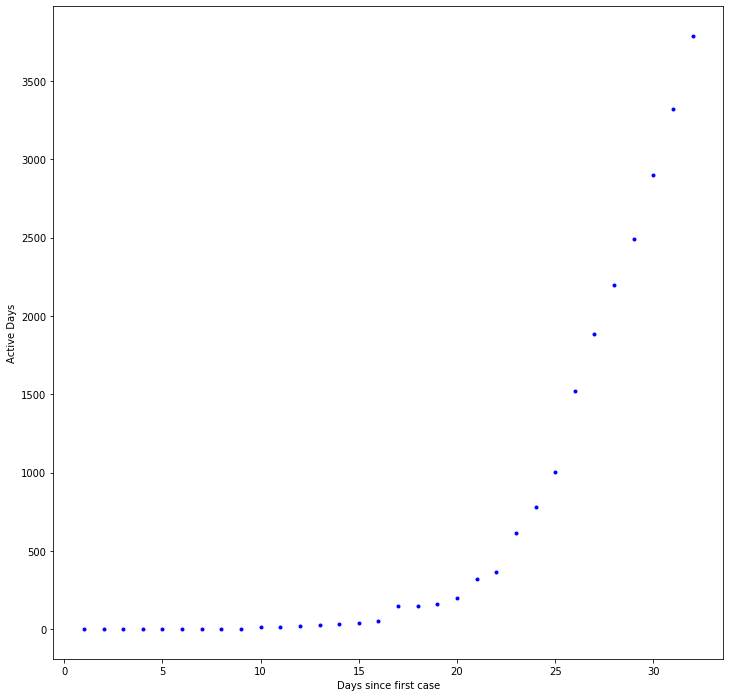

In [2]:
# leitura e ativação dos vetores presentes no arquivo

df = pd.read_csv('./covid19.csv', header=None)
x = df[0].to_numpy()
y = df[1].to_numpy()
X =  x.reshape(len(y), 1)
y =  y.reshape(len(y), 1)
include_bias = False
fig = plt.figure(figsize=(12,12))
plt.plot(x, y, 'b.')
plt.xlabel('Days since first case',  fontsize=10)
plt.ylabel('Active Days',  fontsize=10)
plt.show()

In [3]:
# Houdout %

starttime = timeit.default_timer()
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print('Size of Training Set:', len(y_train))
print('Size of Validation Set:', len(y_val))
error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    
    std_scaler = StandardScaler()
    
    lin_reg = LinearRegression()
    
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    polynomial_regression.fit(x_train, y_train)
    
    y_train_predict = polynomial_regression.predict(x_train)
    
    y_val_predict = polynomial_regression.predict(x_val)    
    
    error_train.append(np.sqrt(mean_squared_error(y_train, y_train_predict)))

    error_val.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))

print("Time Excecution: %1.4f [s]" % (timeit.default_timer() - starttime))    

Size of Training Set: 25
Size of Validation Set: 7
Time Excecution: 0.0232 [s]


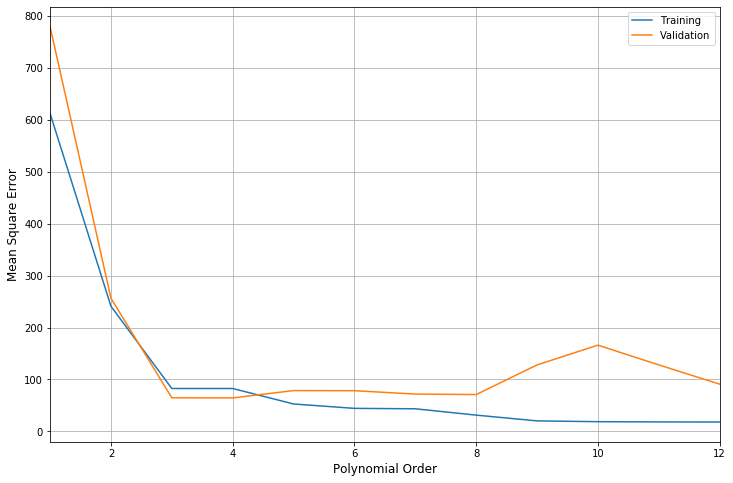

In [4]:
# Plotagem Mean Square x Holdout

plt.figure(figsize=(12, 8))
plt.plot(range(1, 13), error_train, label='Training')
plt.plot(range(1, 13), error_val, label='Validation')
plt.xlabel('Polynomial Order',  fontsize=12)
plt.ylabel('Mean Square Error',  fontsize=12)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()
plt.show()

In [5]:
# Fabricação de K-fold (K=10)
starttime = timeit.default_timer()
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
error_train = []
error_val = []
mean_vec = []
std_vec = []
for d in range(1, 13):
    
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    
    std_scaler = StandardScaler()
    
    lin_reg = LinearRegression()
  
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=kfold)
    
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())

print("Time Execution: %1.4f [s]" % (timeit.default_timer() - starttime))    

Time Execution: 0.1917 [s]


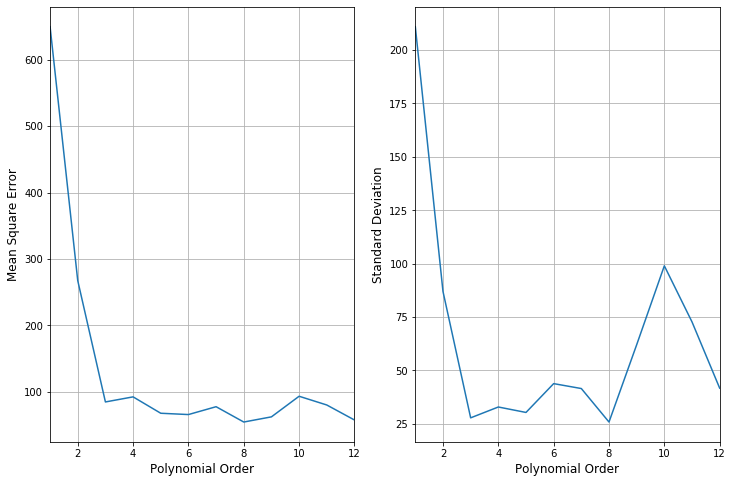

In [6]:
# Expectativa de plotagem MS Error + SD K-fold

plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Polynomial Order',  fontsize=12)
plt.ylabel('Mean Square Error',  fontsize=12)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()
ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Polynomial Order',  fontsize=12)
plt.ylabel('Standard Deviation',  fontsize=12)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()
plt.show()

In [7]:
# Aplicando Leave-p-out (P=1)

starttime = timeit.default_timer()
lpocv = LeavePOut(p=1)
mean_vec = []
std_vec = []
for d in range(1, 13):
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    lin_scores = cross_val_score(polynomial_regression, X, y, scoring='neg_mean_squared_error', cv=lpocv)    
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std()) 
print("Time Execution: %1.4f [s]" % (timeit.default_timer() - starttime))


Time Execution: 0.5476 [s]


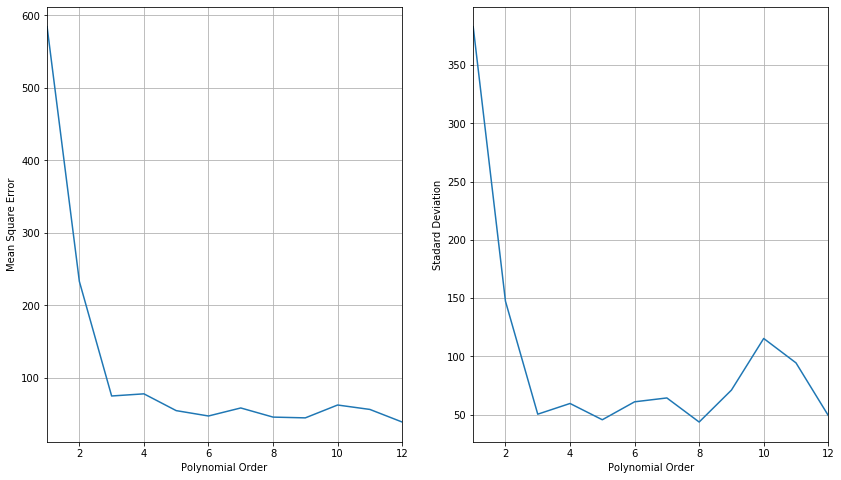

In [8]:
# Expectativa de plotagem MS Error + SD Leave-p-out

plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 13), mean_vec)
plt.xlabel('Polynomial Order', fontsize=10)
plt.ylabel('Mean Square Error', fontsize=10)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()
ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 13), std_vec)
plt.xlabel('Polynomial Order', fontsize=10)
plt.ylabel('Stadard Deviation', fontsize=10)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.grid()
plt.show()

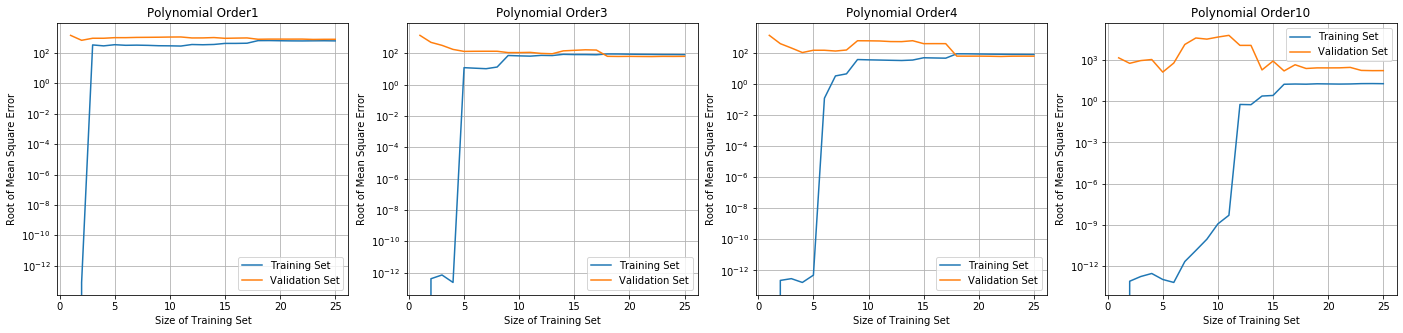

In [9]:
# Exibição e plotagem das curvas de aprendizado respectivas

degrees = [1, 3, 4, 10]
plt.figure(figsize=(24, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)

    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    
    std_scaler = StandardScaler()
    
    lin_reg = LinearRegression()

    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])

    error_training = []
    error_validation = []
    error_test = []
    for m in range(1,len(x_train)+1):

        polynomial_regression.fit(x_train[:m], y_train[:m])
        
        y_train_predict = polynomial_regression.predict(x_train[:m])
        
        y_val_predict = polynomial_regression.predict(x_val)       
        
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        
        error_validation.append(mean_squared_error(y_val, y_val_predict))     

    plt.plot(range(1,len(x_train)+1), np.sqrt(error_training), label='Training Set')
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_validation), label='Validation Set')
    plt.yscale('log')
    plt.xlabel('Size of Training Set', fontsize=10)
    plt.ylabel('Root of Mean Square Error', fontsize=10)
    plt.grid()
    plt.title('Polynomial Order'+str(degrees[i]))
    plt.legend(loc='best')
    
plt.show()

In [10]:
# Modelo de treinamento e melhor valor

degree = 3
include_bias = False
poly_features = PolynomialFeatures(degree=degree, include_bias=include_bias)
std_scaler = StandardScaler()
lin_reg = LinearRegression()
model = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])

model.fit(X, y)
X_pred = np.arange(1, 70).reshape(-1, 1)
y_pred = model.predict(X_pred)
X_pred = X_pred.reshape(1, -1)[0]

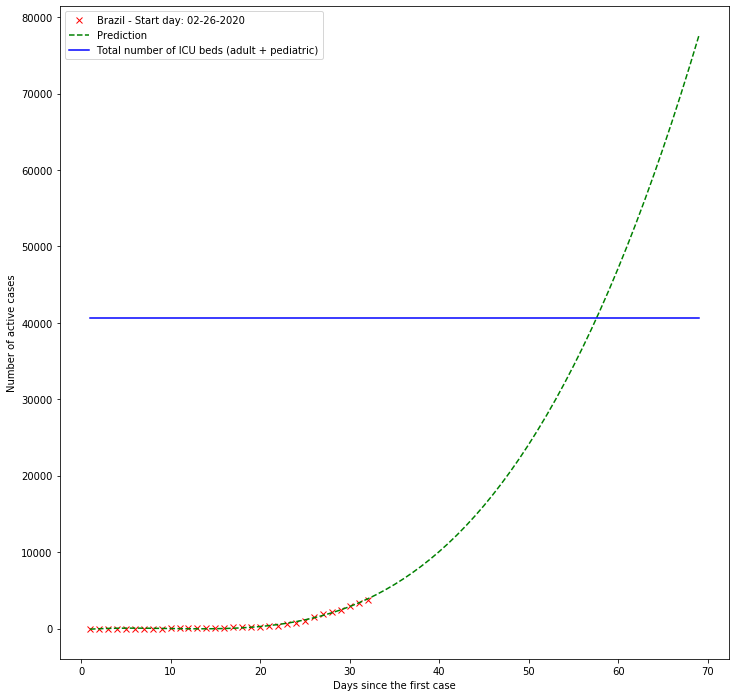

In [11]:
# Casos após 70 dias (predição)

plt.figure(figsize=(12, 12))
plt.plot(X,y,'rx',label='Brazil - Start day: 02-26-2020')
plt.plot(X_pred,y_pred,'g--',label='Prediction')
plt.plot(X_pred,40600*np.ones(len(X_pred)),'b',label='Total number of ICU beds (adult + pediatric)')
plt.xlabel('Days since the first case', fontsize=10)
plt.ylabel('Number of active cases', fontsize=10)
plt.legend()
plt.show()

In [12]:
# Colapso de leitos de UTI

colapso_de_leitos_UTI = min([i+1 for i,v in enumerate(y_pred) if v >= 40600])
print('Collapse of ICU beds: ', colapso_de_leitos_UTI)

Collapse of ICU beds:  58
